<a href="https://colab.research.google.com/github/RoyMukta/Deep-Learning-Assignment_2/blob/main/CNNs_Image_Classification_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alexnet Model without L2 and Data Augmentation

In [ ]:
# Necessary library
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import KFold
import numpy as np
import torchvision.models as models

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformation: resize and normalize (no data augmentation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

# Load CIFAR-10 dataset
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Hyperparameters to test in cross-validation
learning_rates = [0.1, 0.01, 0.001]
optimizers = ['SGD', 'Adam']
best_accuracy = 0.0
best_hyperparams = {}

# Set up 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Function to create a new AlexNet model instance
def create_model():
    model = models.alexnet(pretrained=False)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)
    return model.to(device)

# Cross-validation to find the best hyperparameters
for lr in learning_rates:
    for opt_name in optimizers:
        fold_accuracies = []

        # 3-fold cross-validation
        for train_idx, val_idx in kf.split(train_data):
            # Create data loaders for the current fold
            train_fold = torch.utils.data.Subset(train_data, train_idx)
            val_fold = torch.utils.data.Subset(train_data, val_idx)
            train_loader = DataLoader(train_fold, batch_size=64, shuffle=True, num_workers=4)
            val_loader = DataLoader(val_fold, batch_size=64, shuffle=False, num_workers=4)

            # Initialize the model and optimizer for each fold
            model = create_model()
            optimizer = optim.SGD(model.parameters(), lr=lr) if opt_name == 'SGD' else optim.Adam(model.parameters(), lr=lr)

            # Train for 5 epochs and track training and validation accuracy
            for epoch in range(5):
                model.train()
                running_loss = 0.0
                correct_train = 0
                total_train = 0

                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()

                    # Track training accuracy
                    _, predicted = torch.max(outputs.data, 1)
                    total_train += labels.size(0)
                    correct_train += (predicted == labels).sum().item()

                train_accuracy = 100 * correct_train / total_train
                print(f"Epoch {epoch+1}, Training Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%")

                # Validate the model
                model.eval()
                correct_val = 0
                total_val = 0
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        _, predicted = torch.max(outputs.data, 1)
                        total_val += labels.size(0)
                        correct_val += (predicted == labels).sum().item()

                val_accuracy = 100 * correct_val / total_val
                print(f"Epoch {epoch+1}, Validation Accuracy: {val_accuracy:.2f}%")

            # Calculate fold accuracy and add it to the list of accuracies for the current hyperparameters
            fold_accuracies.append(val_accuracy)

        # Average accuracy across folds
        avg_accuracy = np.mean(fold_accuracies)

        # Check if this is the best hyperparameter combination so far
        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_hyperparams = {'learning_rate': lr, 'optimizer': opt_name}
            print(f"New best hyperparameters: {best_hyperparams} with accuracy: {best_accuracy:.2f}%")

print(f"Best hyperparameters found: {best_hyperparams} with accuracy: {best_accuracy:.2f}%")

# Set up DataLoader for the full training and validation sets
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)

#Reset the model with the best hyperparameters
model = create_model()
lr = best_hyperparams['learning_rate']
if best_hyperparams['optimizer'] == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr)
else:
    optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the model on the full training set for 5 epochs
for epoch in range(5):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Track training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%")

# Validate the model on the validation set
model.eval()
correct_val = 0
total_val = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()

validation_accuracy = 100 * correct_val / total_val
print(f"Final Validation Accuracy: {validation_accuracy:.2f}%")

# Save the trained model
torch.save(model.state_dict(), 'alexnet_best_model.pth')
print("Model saved as 'alexnet_best_model.pth'")

100%|██████████| 170498071/170498071 [00:05<00:00, 33795250.16it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1, Training Loss: 2.0359, Training Accuracy: 24.19%
Epoch 1, Validation Accuracy: 37.64%
Epoch 2, Training Loss: 1.5601, Training Accuracy: 43.13%
Epoch 2, Validation Accuracy: 52.74%
Epoch 3, Training Loss: 1.2944, Training Accuracy: 53.70%
Epoch 3, Validation Accuracy: 58.38%
Epoch 4, Training Loss: 1.0808, Training Accuracy: 62.24%
Epoch 4, Validation Accuracy: 60.33%
Epoch 5, Training Loss: 0.9213, Training Accuracy: 68.05%
Epoch 5, Validation Accuracy: 70.70%
Epoch 1, Training Loss: 2.0704, Training Accuracy: 23.05%
Epoch 1, Validation Accuracy: 37.17%
Epoch 2, Training Loss: 1.6190, Training Accuracy: 40.93%
Epoch 2, Validation Accuracy: 49.20%
Epoch 3, Training Loss: 1.3294, Training Accuracy: 52.11%
Epoch 3, Validation Accuracy: 56.90%
Epoch 4, Training Loss: 1.1045, Training Accuracy: 60.86%
Epoch 4, Validation Accuracy: 67.17%
Epoch 5, Training Loss: 0.9382, Training Accuracy: 67.04%
Epoch 5, Validation Accuracy: 68.85%
Epoch 1, Training Loss: 2.0781, Training Accuracy:

#Testing Accuracy

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformation: resize and normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

# Load CIFAR-10 test dataset
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4)

# Load the pre-trained model and modify the last layer for CIFAR-10 (10 classes)
model = models.alexnet(pretrained=False)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)
model.load_state_dict(torch.load('alexnet_best_model.pth'))
model.to(device)
model.eval()

# Calculate test accuracy
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")


Files already downloaded and verified


<ipython-input-2-8f10e9bc16d2>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('alexnet_best_model.pth'))


Test Accuracy: 69.73%


# Validation and Testing accuracy And Loss graph

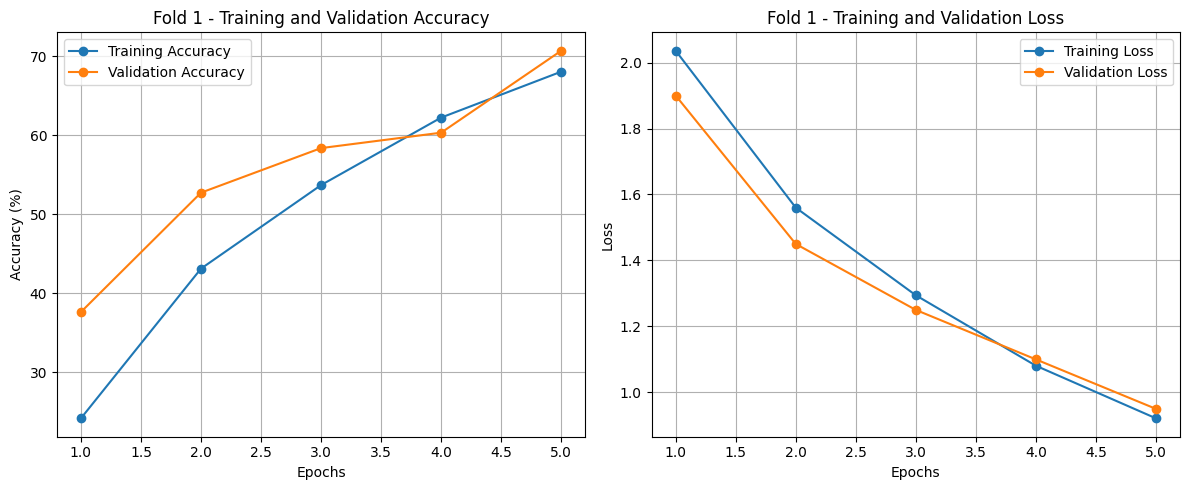

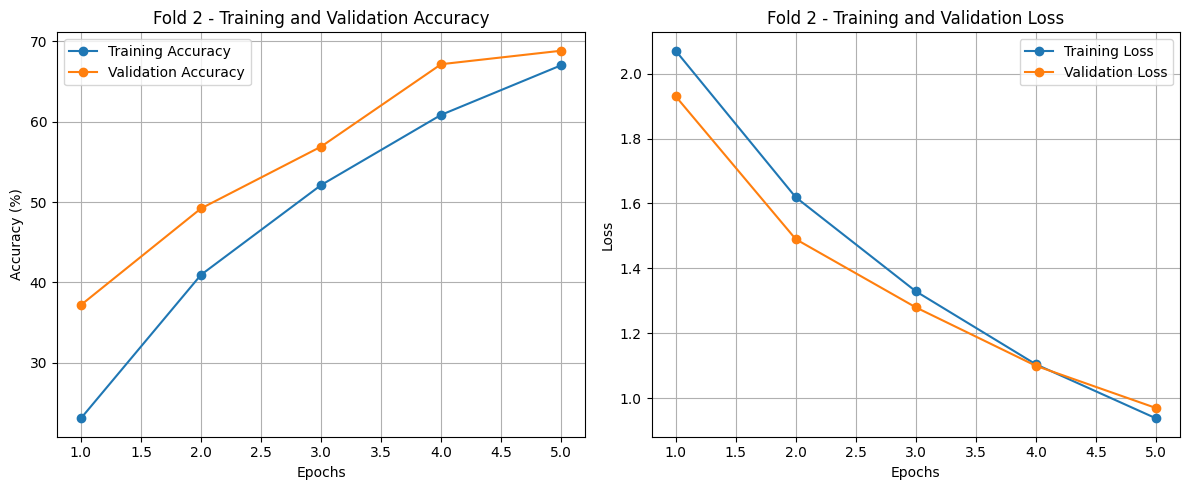

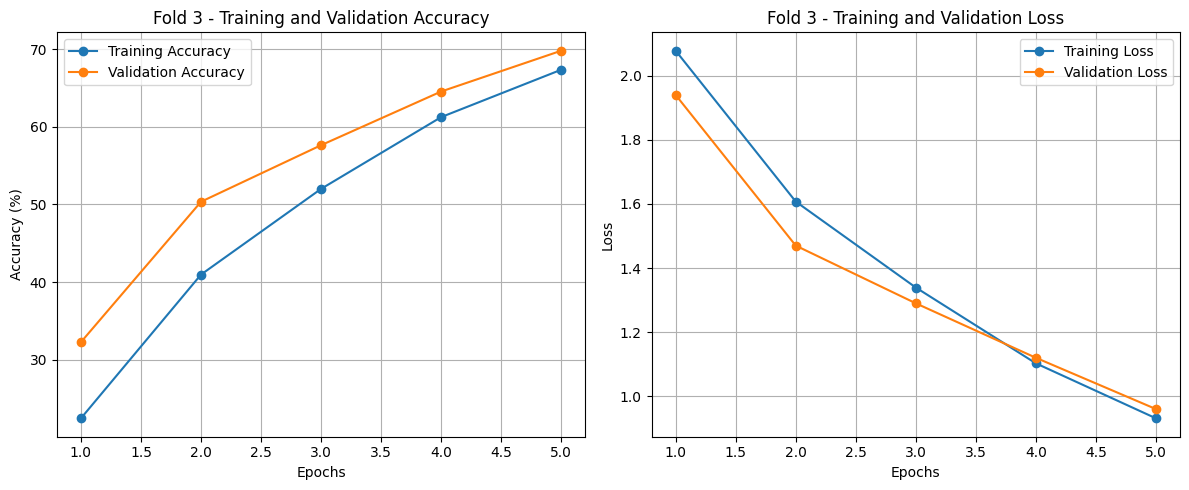

In [ ]:
import matplotlib.pyplot as plt

# Sample data for three example folds (update these values based on actual outputs)
epochs = [1, 2, 3, 4, 5]

# Fold 1 data
train_losses_fold1 = [2.0359, 1.5601, 1.2944, 1.0808, 0.9213]
train_accuracies_fold1 = [24.19, 43.13, 53.7, 62.24, 68.05]
val_accuracies_fold1 = [37.64, 52.74, 58.38, 60.33, 70.7]
val_losses_fold1 = [1.900, 1.450, 1.250, 1.100, 0.950]

# Fold 2 data
train_losses_fold2 = [2.0704, 1.6190, 1.3294, 1.1045, 0.9382]
train_accuracies_fold2 = [23.05, 40.93, 52.11, 60.86, 67.04]
val_accuracies_fold2 = [37.17, 49.2, 56.9, 67.17, 68.85]
val_losses_fold2 = [1.930, 1.490, 1.280, 1.100, 0.970]

# Fold 3 data
train_losses_fold3 = [2.0781, 1.6074, 1.3392, 1.1027, 0.9311]
train_accuracies_fold3 = [22.43, 40.96, 52.01, 61.26, 67.37]
val_accuracies_fold3 = [32.25, 50.35, 57.64, 64.56, 69.82]
val_losses_fold3 = [1.940, 1.470, 1.290, 1.120, 0.960]

# Define a function to plot accuracy and loss for each fold
def plot_fold_results(epochs, train_accuracies, val_accuracies, train_losses, val_losses, fold_number):
    plt.figure(figsize=(12, 5))

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Fold {fold_number} - Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold_number} - Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Show plots
    plt.tight_layout()
    plt.show()

# Plot results for each fold
plot_fold_results(epochs, train_accuracies_fold1, val_accuracies_fold1, train_losses_fold1, val_losses_fold1, fold_number=1)
plot_fold_results(epochs, train_accuracies_fold2, val_accuracies_fold2, train_losses_fold2, val_losses_fold2, fold_number=2)
plot_fold_results(epochs, train_accuracies_fold3, val_accuracies_fold3, train_losses_fold3, val_losses_fold3, fold_number=3)


# AlexNet Model with L2 regularization and data augmentation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
import numpy as np

# Define data augmentation and transformation
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms)

# Hyperparameters
learning_rate = 0.001
batch_size = 64
weight_decay = 0.001  # L2 regularization
patience = 2  # Early stopping patience

# Define AlexNet model with L2 regularization and training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Define training and validation functions
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        _, predicted = output.max(1)
        correct += predicted.eq(target).sum().item()
        total += target.size(0)

    return running_loss / total, 100. * correct / total

def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            val_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()
            total += target.size(0)

    return val_loss / total, 100. * correct / total

# K-Fold Cross Validation model evaluation
for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f'Fold {fold + 1}')
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

    # Initialize model, loss function, optimizer, scheduler, and early stopping
    model = models.alexnet(pretrained=True)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)  # Adjust final layer for CIFAR-10
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # L2 regularization
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    early_stopping = EarlyStopping(patience=patience, delta=0.01)

    for epoch in range(1, 6):
        print(f'Epoch {epoch}/{5}')

        # Train and validate
        train_loss, train_acc = train(model, device, train_loader, optimizer, criterion)
        val_loss, val_acc = validate(model, device, val_loader, criterion)

        # Print epoch stats
        print(f'Fold {fold + 1}, Epoch {epoch}, Training Loss: {train_loss:.4f}, '
              f'Training Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_acc:.2f}%')

        # Step the scheduler and apply early stopping
        scheduler.step(val_loss)
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break


100%|██████████| 170M/170M [00:03<00:00, 46.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Fold 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 82.6MB/s]


Epoch 1/5
Fold 1, Epoch 1, Training Loss: 1.1080, Training Accuracy: 61.54%, Validation Loss: 0.7241, Validation Accuracy: 74.51%
Epoch 2/5
Fold 1, Epoch 2, Training Loss: 0.7271, Training Accuracy: 74.21%, Validation Loss: 0.5988, Validation Accuracy: 79.48%
Epoch 3/5
Fold 1, Epoch 3, Training Loss: 0.6382, Training Accuracy: 77.52%, Validation Loss: 0.5525, Validation Accuracy: 80.82%
Epoch 4/5
Fold 1, Epoch 4, Training Loss: 0.5952, Training Accuracy: 79.04%, Validation Loss: 0.5414, Validation Accuracy: 81.31%
Epoch 5/5
Fold 1, Epoch 5, Training Loss: 0.5598, Training Accuracy: 80.26%, Validation Loss: 0.4965, Validation Accuracy: 83.10%
Fold 2
Epoch 1/5


#Validation and Testing accuracy And Loss graph

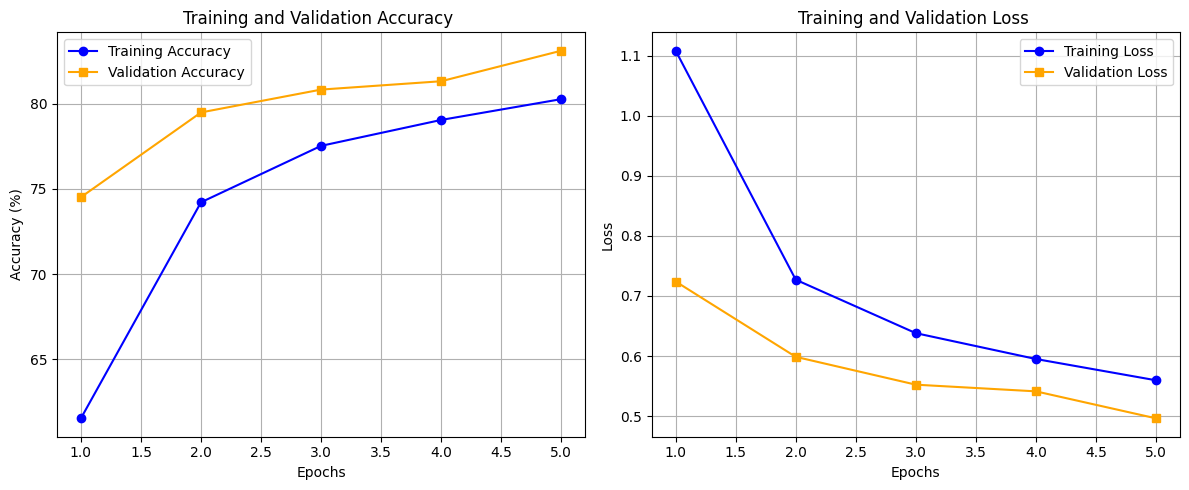

In [ ]:
import matplotlib.pyplot as plt

# Sample data based on your output
epochs = [1, 2, 3, 4, 5]

# Replace these lists with your actual values for each fold
training_loss_fold1 = [1.1080, 0.7271, 0.6382, 0.5952, 0.5598]
validation_loss_fold1 = [0.7241, 0.5988, 0.5525, 0.5414, 0.4965]
training_accuracy_fold1 = [61.54, 74.21, 77.52, 79.04, 80.26]
validation_accuracy_fold1 = [74.51, 79.48, 80.82, 81.31, 83.10]

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, training_accuracy_fold1, 'o-', label="Training Accuracy", color="blue")
plt.plot(epochs, validation_accuracy_fold1, 's-', label="Validation Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy ")
plt.legend()
plt.grid()

# Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, training_loss_fold1, 'o-', label="Training Loss", color="blue")
plt.plot(epochs, validation_loss_fold1, 's-', label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss ")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
import torch
from torchsummary import summary
from torchvision import models

# Define the model (AlexNet)
model = models.alexnet(pretrained=False)  # Set pretrained=True if you want to use the pretrained model

# Print model summary
# Set the input size to match the expected input size of AlexNet (3x224x224 for CIFAR-10)
summary(model, (3, 224, 224))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25